## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
%matplotlib inline 
import geopandas as gdp

## Import dataset

In [2]:
df = pd.read_excel("ANZ synthesised transaction dataset.xlsx")
df.shape

(12043, 23)

There are 12,0403 rows of transactions by 23 columns of data

## Exploratory Data Analysis

In [3]:
# Getting info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12043 entries, 0 to 12042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   status             12043 non-null  object        
 1   card_present_flag  7717 non-null   float64       
 2   bpay_biller_code   885 non-null    object        
 3   account            12043 non-null  object        
 4   currency           12043 non-null  object        
 5   long_lat           12043 non-null  object        
 6   txn_description    12043 non-null  object        
 7   merchant_id        7717 non-null   object        
 8   merchant_code      883 non-null    float64       
 9   first_name         12043 non-null  object        
 10  balance            12043 non-null  float64       
 11  date               12043 non-null  datetime64[ns]
 12  gender             12043 non-null  object        
 13  age                12043 non-null  int64         
 14  mercha

In [4]:
# Checking for null values
df.isna().sum()

status                   0
card_present_flag     4326
bpay_biller_code     11158
account                  0
currency                 0
long_lat                 0
txn_description          0
merchant_id           4326
merchant_code        11160
first_name               0
balance                  0
date                     0
gender                   0
age                      0
merchant_suburb       4326
merchant_state        4326
extraction               0
amount                   0
transaction_id           0
country                  0
customer_id              0
merchant_long_lat     4326
movement                 0
dtype: int64

`bpay_biller_code` and `merchant_code` has almost 92% missing values. It is best to drop or ignore these columns.

`merchant_id`, `merchant_suburb` and `merchant_state` has almost 35% missing values. It is not wise to make any analysis based off these columns.

### Exploring txn_description

In [5]:
# Exploring all unique values in txn_description
df.txn_description.unique()

array(['POS', 'SALES-POS', 'PAYMENT', 'INTER BANK', 'PAY/SALARY',
       'PHONE BANK'], dtype=object)

### Extract Day from Date

In [6]:
df['date'].head()

0   2018-08-01
1   2018-08-01
2   2018-08-01
3   2018-08-01
4   2018-08-01
Name: date, dtype: datetime64[ns]

In [7]:
df['day_date'] = df['date'].dt.day_name()
df['day_date'].head()

0    Wednesday
1    Wednesday
2    Wednesday
3    Wednesday
4    Wednesday
Name: day_date, dtype: object

### Exploring Gender Segment

In [8]:
# Obtaining all 100 unique customers
df_unique = df.drop_duplicates(subset=['account'])

# Obtaining gender count
df_gender = df_unique.groupby('gender',as_index=False).count()
df_gender = df_gender[['gender','status']]

# Obtain gender percentage
df_gender['status'] = df_gender['status']/df_gender['status'].sum()
df_gender

,gender,status
0,F,0.44
1,M,0.56


The customer segment is `56% Male` and `44% Female`.

### Exploring Age Segment

In [9]:
age = df['age'].unique()
age.sort()
age

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35,
       37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 50, 52, 53, 64, 69, 78],
      dtype=int64)

In [10]:
bins = [18,20,30,40,50,60,70,120]
age_label = ['18-19','20-29','30-39','40-49','50-59','60-69','70+']
df['age_label'] = pd.cut(df['age'], bins, labels = age_label, include_lowest =True)

In [11]:
df[['age','age_label']].head()

,age,age_label
0,26,20-29
1,26,20-29
2,38,30-39
3,40,30-39
4,26,20-29


## Transaction Insights
### Average transaction amount across 3 months (General)

In [12]:
# Obtain the average transaction amount from total transaction
avg_trans = round(df['amount'].mean(),2)
print('The average transaction amount is',avg_trans)

The average transaction amount is 187.93


### Average transaction amount across 3 months (Gender)

In [13]:
avg_trans_gender = round(df.groupby('gender').mean(),2)
avg_trans_gender = avg_trans_gender['amount']
avg_trans_gender

gender
F    168.52
M    205.72
Name: amount, dtype: float64

We are able to see that `Male` has a `higher` average transaction amount as compared to `Female`. 

### Average transaction amount across 3 months (Age)

In [14]:
avg_trans_age = round(df.groupby('age_label').mean(),2)
avg_trans_age['amount']

age_label
18-19    180.06
20-29    165.53
30-39    204.93
40-49    228.43
50-59    323.41
60-69    154.04
70+      318.98
Name: amount, dtype: float64

In [15]:
avg_trans_age = avg_trans_age.reset_index()

# Extract values to be plotted in bar chart
age_label = avg_trans_age['age_label'].values.tolist()
age_amount = avg_trans_age['amount'].values.tolist()

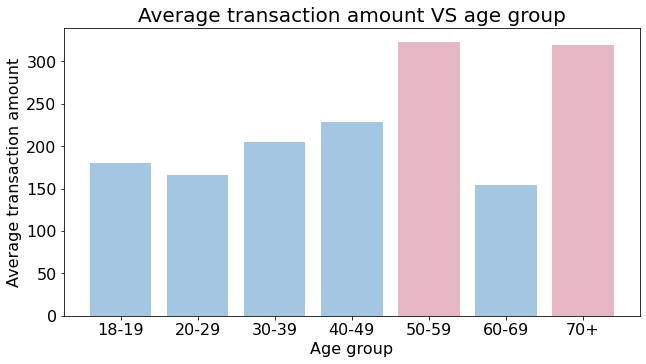

In [16]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(age_label,age_amount,color=['#a3c7e2','#a3c7e2','#a3c7e2','#a3c7e2','#e6b8c4','#a3c7e2','#e6b8c4'])
ax.set_xlabel('Age group')
ax.set_ylabel('Average transaction amount')
plt.title('Average transaction amount VS age group',fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
plt.show()

The general average transaction amount is 187.93.

The age group `50-59`and `70+` has unusual average transaction amount.

* The `50-59` and `70+` age group has a high average transaction amount

### Average credit and debit amount across 3 months (General)

In [17]:
# Filter by credit and debit
df_credit = df.loc[df['movement']=='credit']
df_debit = df.loc[df['movement']=='debit']

In [18]:
# Obtain the average credit amount from total transaction
avg_trans_credit = round(df_credit['amount'].mean(),2)
print('The average credit amount is',avg_trans_credit)

# Obtain the average debit amount from total transaction
avg_trans_debit = round(df_debit['amount'].mean(),2)
print('The average debit amount is',avg_trans_debit)

The average credit amount is 1898.73
The average debit amount is 52.57


### Average credit and debit amount across 3 months (Gender)

In [19]:
avg_trans_gender_credit = round(df_credit.groupby('gender').mean(),2)
avg_trans_gender_credit = avg_trans_gender_credit['amount']
avg_trans_gender_credit

gender
F    1679.37
M    2096.81
Name: amount, dtype: float64

We are able to see that `Male` has a `higher average credit` amount than `Female`.

In [20]:
avg_trans_gender_debit = round(df_debit.groupby('gender').mean(),2)
avg_trans_gender_debit = avg_trans_gender_debit['amount']
avg_trans_gender_debit

gender
F    49.95
M    54.98
Name: amount, dtype: float64

We are able to see that `Male` has a `higher average debit` amount than `Female.

### Average credit and debit amount across 3 months (Age)

In [21]:
avg_trans_age_credit = round(df_credit.groupby('age_label').mean(),2)
avg_trans_age_credit['amount']

age_label
18-19    1940.75
20-29    1932.86
30-39    2117.00
40-49    1673.19
50-59    1955.83
60-69     818.21
70+       782.42
Name: amount, dtype: float64

In [22]:
avg_trans_age_credit = avg_trans_age_credit.reset_index()

# Extract values to be plotted in bar chart
age_credit_amount = avg_trans_age_credit['amount'].values.tolist()

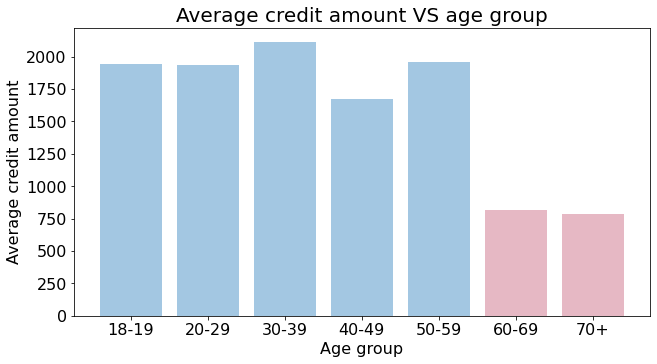

In [23]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(age_label,age_credit_amount,color=['#a3c7e2','#a3c7e2','#a3c7e2','#a3c7e2','#a3c7e2','#e6b8c4','#e6b8c4'])
ax.set_xlabel('Age group')
ax.set_ylabel('Average credit amount')
plt.title('Average credit amount VS age group',fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
plt.show()

The general average credit amount is 1898.73.

The age group `60-69` and `70+` has unusual average credit amount.

* The `60-69` and `70+` age group has significantly lower average credit amount.

In [24]:
avg_trans_age_debit = round(df_debit.groupby('age_label').mean(),2)
avg_trans_age_debit['amount']

age_label
18-19    46.47
20-29    48.47
30-39    55.38
40-49    69.69
50-59    72.27
60-69    44.02
70+      66.19
Name: amount, dtype: float64

In [25]:
avg_trans_age_debit = avg_trans_age_debit.reset_index()

# Extract values to be plotted in bar chart
age_debit_amount = avg_trans_age_debit['amount'].values.tolist()

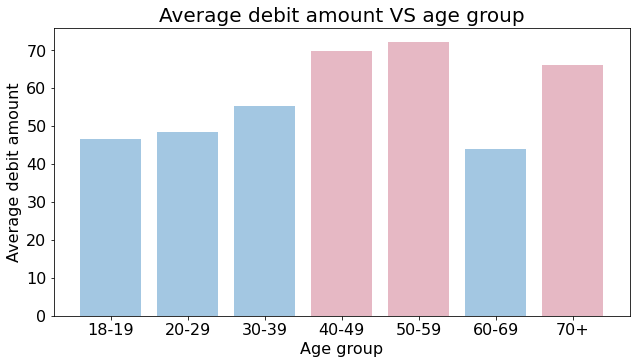

In [26]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(age_label,age_debit_amount,color=['#a3c7e2','#a3c7e2','#a3c7e2','#e6b8c4','#e6b8c4','#a3c7e2','#e6b8c4'])
ax.set_xlabel('Age group')
ax.set_ylabel('Average debit amount')
plt.title('Average debit amount VS age group',fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
plt.show()

The general average debit amount is 52.57.

The age group `40-49`, `50-59` and `70+` has unusual average debit amount.

These age group has a higher than average debit amount as compared to the other age groups.

### Average balance for customers (General)

In [27]:
# Obtain the average balance for customer
avg_balance = round(df['balance'].mean(),2)
print('The average balance amount is',avg_balance)

The average balance amount is 14704.2


### Average balance for customers (Gender)

In [28]:
avg_balance_gender = round(df.groupby('gender').mean(),2)
avg_balance_gender = avg_balance_gender['balance']
avg_balance_gender

gender
F    12061.26
M    17125.52
Name: balance, dtype: float64

We can see that `Male` has a `higher average balance` as compared to `Female`.

### Average balance for customers (Age)

In [29]:
avg_balance_age = round(df.groupby('age_label').mean(),2)
avg_balance_age['balance']

age_label
18-19     9125.13
20-29     8568.92
30-39    22079.35
40-49    28951.02
50-59     6324.48
60-69     4658.84
70+      54240.64
Name: balance, dtype: float64

In [30]:
avg_balance_age = avg_balance_age.reset_index()

# Extract values to be plotted in bar chart
age_bal_amount = avg_balance_age['balance'].values.tolist()

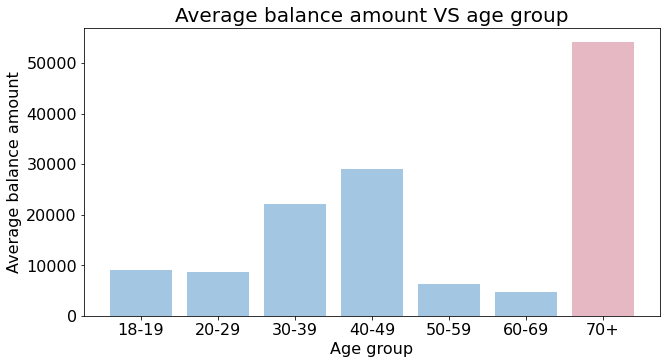

In [31]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(age_label,age_bal_amount,color=['#a3c7e2','#a3c7e2','#a3c7e2','#a3c7e2','#a3c7e2','#a3c7e2','#e6b8c4'])
ax.set_xlabel('Age group')
ax.set_ylabel('Average balance amount')
plt.title('Average balance amount VS age group',fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
plt.show()

The general average balance amount is 14704.20.

The balance for age group 70+ seems `very high` as compared to the `other age groups`.

It looks slightly suspicious. 

In [32]:
# Counting number of customers in each age group
age_count_df = df.groupby('age_label')
age_count_df = age_count_df.agg({'account':'nunique'})
age_count_df.reset_index()

,age_label,account
0,18-19,16
1,20-29,38
2,30-39,26
3,40-49,15
4,50-59,2
5,60-69,2
6,70+,1


As suspected, there is only `1 customer` that falls under the age group 70+. 

This customer may be an `outlier`as the `sample size is too small` to make any solid conclusion.

### Customer segmentation insights
#### Gender
* Overall, `Male` has `higher` `transaction amount`, `credit amount`, `debit amount` and `balance` compared to `Female`
* This makes sense as a higher credit amount and balance enables a higher debit amount
* The higher credit amount also contributes to the higher transaction amount

#### Age
* The `70+` age group is the most interesting age group as it has the highest balance amount. Even with the `least average credit amount`, the `average debit amount is still higher` than the average debit amount of other age group. However, as previously mentioned, the `sample size is too small` to draw any solid conclusion.
* It is also interesting to see the `average balance growing` from the `20-29` age group till the `40-49` age group. However, there is a `sudden decrease` in the average balance of people in the `50-59` age group. This may be due to the `average debit amount` of people in the `50-59` age group being the `highest` among all other age groups.

## Analysing debit transactions

### Average number of transaction per month

In [33]:
# Average transaction number per month
month_df = df_debit.groupby(df['date'].dt.strftime("%b")).count()
month_df = month_df.drop(['date'],axis=1).reset_index()

# Re-arrange month in ascending order
month_df['month'] = pd.Categorical(month_df['date'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
month_df = month_df.sort_values("month").reset_index()

# Extract only month and transaction count
month_df = month_df[['date','status']]
month_df

,date,status
0,Aug,3645
1,Sep,3741
2,Oct,3774


In [34]:
# Extract values to be plotted in bar chart
month_list = month_df['date'].values.tolist()
status_list = month_df['status'].values.tolist()

### Average transaction amount per month

In [35]:
# Average transaction amount per month
month_amount_df =  df_debit.groupby(df['date'].dt.strftime("%b")).mean().reset_index()

# Re-arrange month in ascending order
month_amount_df['month'] = pd.Categorical(month_amount_df['date'], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
month_amount_df = month_amount_df.sort_values("month").reset_index()

# Extract only month and transaction amount
month_amount_df = month_amount_df[['date','amount']]
month_amount_df

,date,amount
0,Aug,46.672480
1,Sep,57.191820
2,Oct,53.691457


In [36]:
# Extract values to be plotted in bar chart
amount_list = month_amount_df['amount'].values.tolist()

In [37]:
# Attaches a text label above each bar 
def autolabel_1(rects):
    for rect in rects:
        height = rect.get_height()
        ax1.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',color=color1)

# Attaches a text label above each bar 
def autolabel_2(rects):
    for rect in rects:
        height = rect.get_height()
        ax2.annotate('${:.0f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',color=color2)

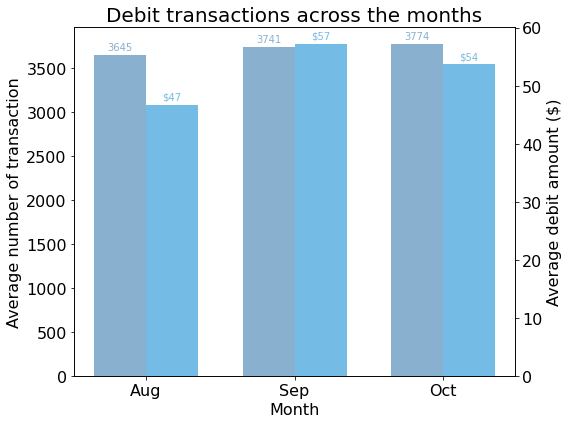

In [38]:
# Plot of dual bar graph
fig, ax1 = plt.subplots(figsize=(8,6))

N = 3
x = np.arange(N)
width = 0.35

# Bar colors
color1 = '#89b0ce'
color2 = "#74bbe5"

# First bar graph
rects1 = ax1.bar(x - width/2, status_list, width,color=color1)
# Second bar graph
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, amount_list, width,color=color2)

# Fine tune display parameters
ax1.set_xlabel('Month')
ax1.set_ylabel('Average number of transaction')
#ax1.tick_params(axis='y',labelcolor=color1)
ax2.set_ylabel('Average debit amount ($)')
#ax2.tick_params(axis='y',labelcolor=color2)
ax2.set_xticks(x)
ax2.set_xticklabels(month_list)

ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax1.xaxis.label.set_size(16)
ax1.yaxis.label.set_size(16)
ax2.yaxis.label.set_size(16)
plt.title('Debit transactions across the months',fontsize=20)

# Using function to display value at top of bar graph
autolabel_1(rects1)
autolabel_2(rects2)
fig.tight_layout()

plt.show()

We are able to see that `October` has the highest number of transaction while `September` has the highest average debit amount per transaction.

### Average number of transaction per day

In [39]:
# Average transaction number per day
day_df = df_debit.groupby(df_debit['day_date']).count().reset_index()

# Re-arrange day in ascending order
day_df['day'] = pd.Categorical(day_df['day_date'],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
day_df = day_df.sort_values('day').reset_index()

# Extract day and transaction count
day_df = day_df[['day_date','status']]
day_df

,day_date,status
0,Monday,1153
1,Tuesday,1327
2,Wednesday,1891
3,Thursday,1658
4,Friday,1872
5,Saturday,1709
6,Sunday,1550


In [40]:
# Extract values to be plotted in bar chart
day_list = day_df['day_date'].values.tolist()
day_count = day_df['status'].values.tolist()

### Average transaction amount per day

In [41]:
# Average transaction amount per month
day_amount_df = df_debit.groupby(df_debit['day_date']).mean().reset_index()

# Re-arrange day in ascending order
day_amount_df['day'] = pd.Categorical(day_amount_df['day_date'],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
day_amount_df = day_amount_df.sort_values('day').reset_index()

# Extract day and transaction amount
day_amount_df = day_amount_df[['day_date','amount']]
day_amount_df

,day_date,amount
0,Monday,56.732793
1,Tuesday,55.946390
2,Wednesday,50.216520
3,Thursday,52.881399
4,Friday,47.670759
5,Saturday,54.419286
6,Sunday,53.015845


In [42]:
# Extract values to be plotted in bar chart
day_amount = day_amount_df['amount'].values.tolist()

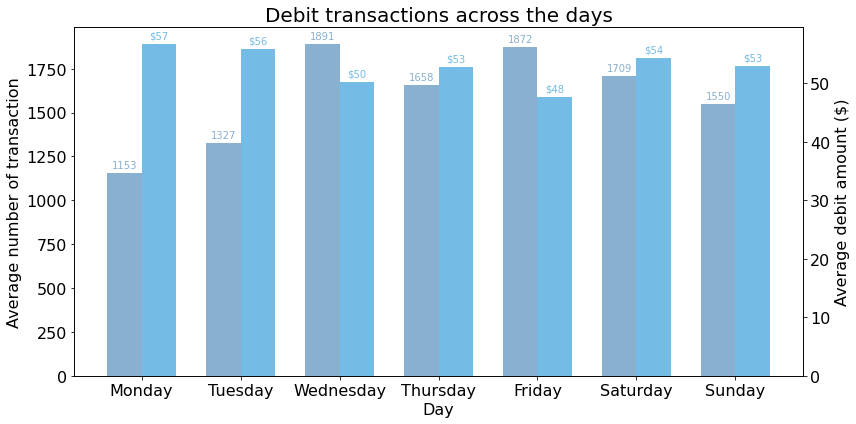

In [43]:
# Plot of dual bar graph
fig, ax1 = plt.subplots(figsize=(12,6))

N = 7
x = np.arange(N)
width = 0.35

# Bar colors
color1 = '#89b0ce'
color2 = "#74bbe5"

# First bar graph
rects1 = ax1.bar(x - width/2, day_count, width,color=color1)
# Second bar graph
ax2 = ax1.twinx()
rects2 = ax2.bar(x + width/2, day_amount, width,color=color2)

# Fine tune display parameters
ax1.set_xlabel('Day')
ax1.set_ylabel('Average number of transaction')
#ax1.tick_params(axis='y',labelcolor=color1)
ax2.set_ylabel('Average debit amount ($)')
#ax2.tick_params(axis='y',labelcolor=color2)
ax2.set_xticks(x)
ax2.set_xticklabels(day_list)

ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax1.xaxis.label.set_size(16)
ax1.yaxis.label.set_size(16)
ax2.yaxis.label.set_size(16)
plt.title('Debit transactions across the days',fontsize=20)

# Using function to display value at top of bar graph
autolabel_1(rects1)
autolabel_2(rects2)
fig.tight_layout()

plt.show()

We are able to see that the `Wednesday` and `Friday` are days where `average number of transactions are highest`.

The average debit amount does not differ too much from day to day.

In [44]:
# Merging transaction count and transaction amount
day_merged_df = pd.merge(day_df,day_amount_df,on=['day_date'])

# Obtaining transaction volume by multiplying count and transaction amount
day_merged_df['volume'] = day_merged_df['status']*day_merged_df['amount']
day_merged_df

,day_date,status,amount,volume
0,Monday,1153,56.732793,65412.91
1,Tuesday,1327,55.946390,74240.86
2,Wednesday,1891,50.216520,94959.44
3,Thursday,1658,52.881399,87677.36
4,Friday,1872,47.670759,89239.66
5,Saturday,1709,54.419286,93002.56
6,Sunday,1550,53.015845,82174.56


In [45]:
# Extract values to be plotted in bar chart
day_count = day_merged_df['volume'].values.tolist()

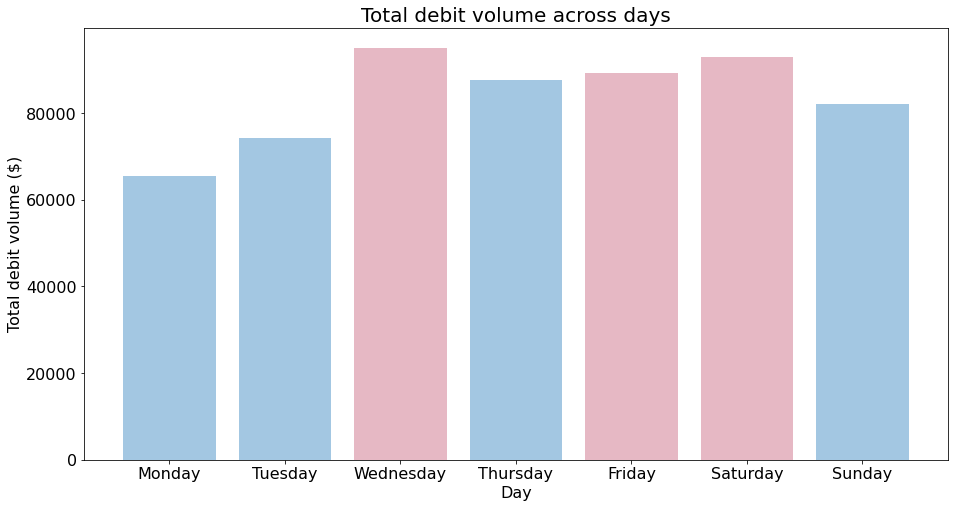

In [46]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0,0,1,1])
ax.bar(day_list,day_count,color=['#a3c7e2','#a3c7e2','#e6b8c4','#a3c7e2','#e6b8c4','#e6b8c4','#a3c7e2'])
ax.set_xlabel('Day')
ax.set_ylabel('Total debit volume ($)')
plt.title('Total debit volume across days',fontsize=20)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
plt.show()

However, when taking account of `volume of debit` (average number of transaction * average debit amount), the ranking changes slightly.

The highest volume occurs in the following order:

* Wednesday
* Saturday
* Friday

This is due to the fact that the `average debit amount` on `Saturday` being `higher` than `Friday`.

### Transaction Type Insights

In [47]:
# Transaction df to obtain count based on group
txn_df = df.groupby(df['txn_description']).count().reset_index()
txn_df = txn_df[['txn_description','status']].sort_values(by=['status'])

In [48]:
# Extract values to be plotted
txn_key = txn_df['txn_description'].values.tolist()
txn_value = txn_df['status'].values.tolist()

In [49]:
# Extract only Phone Bank txn_description transactions
phone_bank_df = df[df['txn_description'] == 'PHONE BANK']
phone_bank_df = phone_bank_df.groupby('age_label').count().reset_index()
phone_bank_df = phone_bank_df[['age_label','status']]
phone_bank_df['perct'] = phone_bank_df['status']/phone_bank_df['status'].sum()

In [50]:
# Extract values to be plotted in bar chart
age_label_list = phone_bank_df['age_label'].values.tolist()
age_perct = phone_bank_df['perct'].values.tolist()

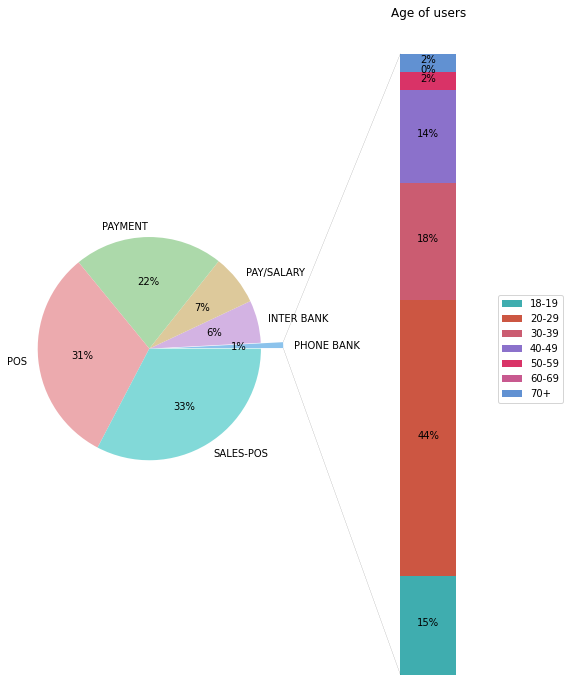

In [51]:
# Make figure and assign axis objects
fig = plt.figure(figsize=(10, 12))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0)

# Plotting pie chart
colors = ["#8cc3ec","#d3b3e3","#ddc99b","#acd9aa","#ecaaae","#82d9d8"]
explode = [0.2, 0, 0,0,0,0]
ax1.pie(txn_value, autopct='%1.0f%%', startangle=0,
        labels=txn_key, explode=explode,labeldistance=1.1,colors=colors)

# Bar chart parameters
xpos = 0
bottom = 0
ratios = age_perct
width = .2
colors =["#3fadaf","#cc5642","#cb5c71","#8b71cb","#d93367","#c8598f","#6191d2"]

# Plotting bar chart
for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom,color=colors[j])
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    ax2.text(xpos, ypos, "%d%%" % (ax2.patches[j].get_height() * 100),
             ha='center')
    
ax2.set_title('Age of users')
ax2.legend((age_label_list),loc=7) 
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# Use ConnectionPatch to draw lines between the two plots
theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
center, r = ax1.patches[0].center, ax1.patches[0].r
bar_height = sum([item.get_height() for item in ax2.patches])

# Draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(0.1)
ax2.add_artist(con)

# Draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(0.1)

plt.show()

ANZ should consider `terminating phone bank operations` as only 1% of it's customer uses it.

Moreover, almost 77% of the phone bank users are from the age group 18-19, 20-29, 30-39. 

These age group are able to `quickly adapt` to `other type of services` with ease.

## Merchant Demographic

In [52]:
# Drop duplicate merchants
unique_merchant = df.drop_duplicates(subset=['merchant_long_lat'])

# Groupby merchant state
merchant_df = unique_merchant.groupby('merchant_state',as_index=False).count()
merchant_df = merchant_df[['merchant_state','status']]

In [53]:
# Number of unique merchants
merchant_df.sum()

merchant_state    ACTNSWNTQLDSATASVICWA
status                             2703
dtype: object

In [54]:
# Extract values to be plotted
merchant_state = merchant_df['merchant_state'].values.tolist()
merchant_count = merchant_df['status'].values.tolist()

In [55]:
# Obtaining map_df
# This data is obtained from 
# https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1270.0.55.003June%202020?OpenDocument
fp = "LGA_2020_AUST.shp"
map_df = gdp.read_file(fp)

In [56]:
# Renaming column
map_df = map_df.rename(columns={"STE_NAME16":"state"})
# Replacing state name to abbreviation
map_df['state'].replace({"New South Wales":"NSW","Victoria":"VIC","Queensland":"QLD","South Australia":"SA","Western Australia":"WA","Tasmania":"TAS","Northern Territory":"NT","Australian Capital Territory":"ACT","Other Territories":"Other"},inplace=True)

In [57]:
# Merging merchant_df and map_df
merged = map_df.merge(merchant_df, left_on='state',right_on='merchant_state')

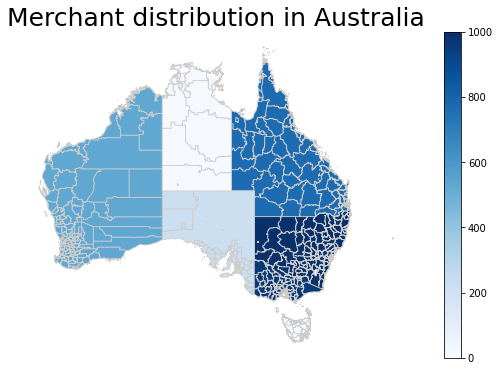

In [58]:
# Plotting Choropleth based on number of merchant 
variable = "status"
# Set the range for the choropleth
vmin, vmax = 0, 1000
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(12, 6))
# Create map
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
# Remove axis
ax.axis('off')
# Add a title
ax.set_title('Merchant distribution in Australia', fontdict={'fontsize': '25', 'fontweight' : '3'})
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# Empty array for the data range
sm._A = []
# Add the colorbar to the figure
cbar = fig.colorbar(sm)
# Saving as image
fig.savefig('map_export.png', dpi=300)

Merchant `density is higher` in states such as `Victoria` and `New South Wales`. 

This makes sense as there are `large cities` such as `Melbourne` and `Sydney` in these states.

ANZ should consider `strengthening its foothold` in the `Northern Territory` as there are very little merchants there.
